In [1]:
import os
import itertools
from pathlib import Path
from typing import List
import warnings
import json


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import NegativeClassOptimization.config as config
import NegativeClassOptimization.utils as utils
import NegativeClassOptimization.preprocessing as preprocessing
from NegativeClassOptimization import ml
from NegativeClassOptimization import datasets, pipelines, visualisations

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
# Example computation
task_dir = "../data/Frozen_MiniAbsolut_ML/high_vs_looser/seed_0/split_0/1ADQ_high__vs__1ADQ_looser"
attr_records_path = Path(task_dir) / 'attributions/v2.0-2/attribution_records.json'

# Load json
with open(attr_records_path, 'r') as f:
    attr_records = json.load(f)

1) AA:Ind frequency
2) AA:Ind relative frequency

In [3]:
from NegativeClassOptimization.preprocessing import compute_frequencies_and_relative, extract_frequences_as_features


# Compute the frequencies and relative frequencies for all, pos and neg slides

all_slides = [attr['slide'] for attr in attr_records]
pos_slides = [attr['slide'] for attr in attr_records if attr['y_true'] == 1]
neg_slides = [attr['slide'] for attr in attr_records if attr['y_true'] == 0]

ohs_freq, ohs_freq_rel = compute_frequencies_and_relative(all_slides)
ohs_freq_pos, ohs_freq_rel_pos = compute_frequencies_and_relative(pos_slides)
ohs_freq_neg, ohs_freq_rel_neg = compute_frequencies_and_relative(neg_slides)

freqs, rel_freqs = extract_frequences_as_features(all_slides, ohs_freq, ohs_freq_rel)
freqs_pos, rel_freqs_pos = extract_frequences_as_features(all_slides, ohs_freq_pos, ohs_freq_rel_pos)
freqs_neg, rel_freqs_neg = extract_frequences_as_features(all_slides, ohs_freq_neg, ohs_freq_rel_neg)

In [4]:
freqs[0].tolist()

[0.0424,
 0.238,
 0.0296,
 0.2648,
 0.034,
 0.2644,
 0.0923,
 0.0491,
 0.009,
 0.2733,
 0.2866]

Now, the features can be added to the attributions in the initial dataframe. They can be saved, and retrieved later for analysis. This is implemented in the script_01_* and run there for all the tasks. The results are later leveraged in this notebook for analysis.

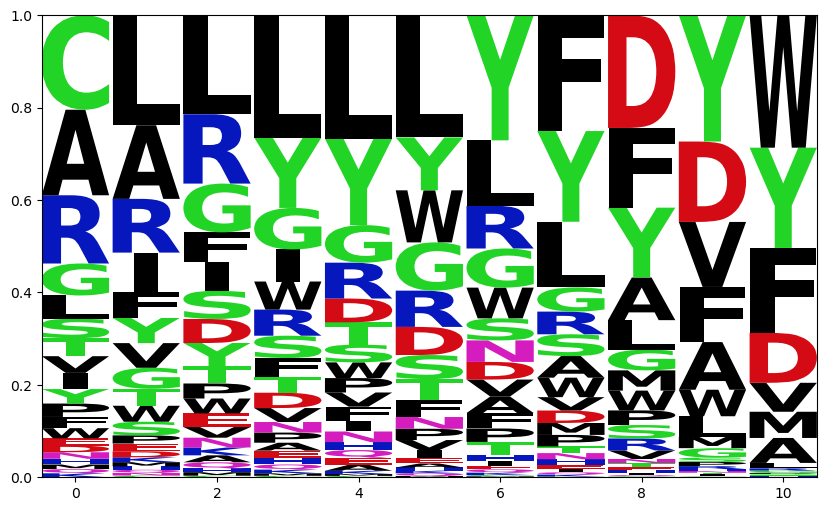

In [5]:
df_attr = pd.DataFrame(ohs_freq.reshape(11, 20), columns=config.AMINOACID_ALPHABET)
visualisations.plot_logo(
    df_attr
    )

Correlations of frequencies and relative frequencies with per-residue energy.

In [6]:
from itertools import permutations


task_types = (
    datasets.ClassificationTaskType.ONE_VS_ONE,
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
)

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)

def task_generator(task_types=task_types, loader=loader):
    """
    Generate tasks for which to compute attributions.
    """
    # Generate 1v1
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1, ag_2 in permutations(config.ANTIGENS, r=2):
        for seed_id, split_id in seed_split_ids:            
            task = datasets.ClassificationTask(
                task_type=datasets.ClassificationTaskType.ONE_VS_ONE,
                ag_pos=ag_1,
                ag_neg=ag_2,
                seed_id=seed_id,
                split_id=split_id,
            )
            yield task

    # Generate the rest: 1v9, high vs 95low, high vs looser
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1 in config.ANTIGENS:
        for seed_id, split_id in seed_split_ids:
            for task_type in task_types:
                
                if task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
                    continue
                
                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )
                yield task


In [27]:
from utils_07 import load_energy_contributions_from_task_nonlinear_version

energy_contributions_path = "../data/Frozen_MiniAbsolut_ML/07e_EnergyContributions_FreqControl.tsv"
force_run_contrib = True
attributor_names = [
    "freq",
    "freq_pos",
    "freq_neg",
    "rel_freq",
    "rel_freq_pos",
    "rel_freq_neg",
]

if Path(energy_contributions_path).exists() and not force_run_contrib:
    df_attrib = pd.read_csv(energy_contributions_path, sep="\t")
else:
    records = []
    for task in task_generator():
        
        try:
            task = loader.load(task, attributions_toload="v2.0-2", attribution_records_toload="attribution_records_augmented.json")
        except:
            continue

        stats_collection = []
        for attributor_name in attributor_names:
            stats = load_energy_contributions_from_task_nonlinear_version(
                task, 
                attributor_name=attributor_name, 
                attribution_records_toload="attribution_records_augmented.json",
                task_is_loaded=True,
                )
            # Rename keys with attributor name
            stats = {f"{attributor_name}_{k}": v for k, v in stats.items()}
            stats_collection.append(stats)
        

        # Merge stats across different attributors
        stats = {k: v for stats in stats_collection for k, v in stats.items()}
        # Add task info
        stats["task_type"] = stats["freq_" + "task_type"]
        stats["ag_pos"] = stats["freq_" + "ag_pos"]
        stats["ag_neg"] = stats["freq_" + "ag_neg"]
        stats["seed_id"] = stats["freq_" + "seed_id"]
        stats["split_id"] = stats["freq_" + "split_id"]
        
        records.append(stats)
    
    df_attrib = pd.DataFrame.from_records(records)
    df_attrib.to_csv(energy_contributions_path, index=False, sep='\t')

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scip

KeyboardInterrupt: 

In [28]:
df_attrib

,freq_task_type,freq_ag_pos,freq_ag_neg,freq_seed_id,freq_split_id,freq_mean,freq_std,freq_mean_pos,freq_std_pos,freq_mean_neg,...,rel_freq_neg_std_total,rel_freq_neg_mean_pos_total,rel_freq_neg_std_pos_total,rel_freq_neg_mean_neg_total,rel_freq_neg_std_neg_total,task_type,ag_pos,ag_neg,seed_id,split_id
0,1v9,3VRL,auto,0,42,-0.320305,0.280943,-0.320305,0.280943,NaN,...,0.284325,-0.245296,0.284325,NaN,NaN,1v9,3VRL,auto,0,42


In [10]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_attrib, 
    x="task_type", 
    y="mean_pos_total", 
    order=task_order,
    hue="ag_pos",
    ax=ax,
    cmap=visualisations.PlotParams.cmap_antigens,
)

ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_attrib.groupby(["task_type"]).agg({"mean_pos_total": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.87,
        f"{row['mean_pos_total']:.2f}",
        # Center center
        horizontalalignment='center',
    )

# ax.set_title("Mean{Correlation(Energycontribution, Attribution)} for positive class")
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/seaborn/categorical.py:299: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/tmp/ipykernel_882931/1171396604.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


Text(0.5, 0, 'Task')